<a href="https://colab.research.google.com/github/Okocha76/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import style
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp
from scipy import stats

## Load and clean the Data

In [4]:
column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data", header=None, names=column_headers, na_values="?")
df = df.replace({'y': 1, 'n': 0})
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [5]:
rep = df[df['party']=='republican']
rep.describe()

,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
count,165.000000,148.000000,164.000000,165.000000,165.000000,166.000000,162.000000,157.000000,165.000000,165.000000,159.000000,155.000000,158.000000,161.000000,156.000000,146.000000
mean,0.187879,0.506757,0.134146,0.987879,0.951515,0.897590,0.240741,0.152866,0.115152,0.557576,0.132075,0.870968,0.860759,0.981366,0.089744,0.657534
std,0.391804,0.501652,0.341853,0.109760,0.215442,0.304104,0.428859,0.361010,0.320176,0.498186,0.339643,0.336322,0.347298,0.135649,0.286735,0.476168
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
dem = df[df['party']=='democrat']
dem.describe()

,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
count,258.000000,239.000000,260.000000,259.000000,255.000000,258.000000,259.000000,263.000000,248.000000,263.000000,255.000000,249.000000,252.000000,257.000000,251.000000,185.000000
mean,0.604651,0.502092,0.888462,0.054054,0.215686,0.476744,0.772201,0.828897,0.758065,0.471483,0.505882,0.144578,0.289683,0.350195,0.637450,0.935135
std,0.489876,0.501045,0.315405,0.226562,0.412106,0.500430,0.420224,0.377317,0.429121,0.500138,0.500949,0.352383,0.454518,0.477962,0.481697,0.246956
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Generate and numerically represent a confidence interval

In [0]:
def confidence_interval(data, confidence=0.95):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

In [13]:
def confidence_interval_dataframe(df):
  
  confidence_intervals = []
  
  # Turn dataframe into a numpy array
  # List values by column and not by row
  df = df.values.T
  
  # Remove nan values from columns
  cleaned_df = []
  for col in df:
    cleaned_col = col[~np.isnan(col)]
    
    # Calculate Confidence interval for each issue
    confidence_intervals.append(confidence_interval(cleaned_col))
    
  confidence_intervals = pd.DataFrame(confidence_intervals, columns=['mean', 'lower', 'upper'])  
    
  return confidence_intervals

# We only want the issue columns not the string "party" column
only_votes = dem.drop('party', axis='columns')

confidence_interval_df = confidence_interval_dataframe(only_votes)
confidence_interval_df.head()

,mean,lower,upper
0,0.604651,0.544593,0.664710
1,0.502092,0.438245,0.565939
2,0.888462,0.849944,0.926980
3,0.054054,0.026332,0.081776
4,0.215686,0.164863,0.266509


## Graphically represent the confidence interval

Text(0, 0.5, "Percent of Democrats voting 'yes'")

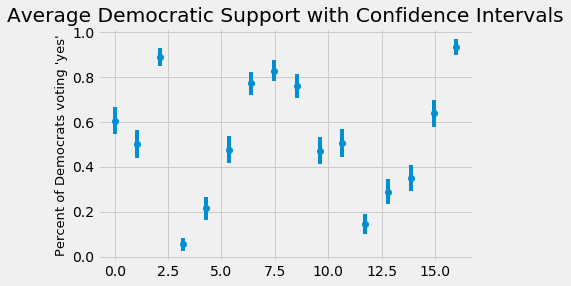

In [11]:
x = np.linspace(0, confidence_interval_df.shape[0], confidence_interval_df.shape[0])
y = confidence_interval_df['mean']
yerr = confidence_interval_df['margin_of_error']


plt.style.use('fivethirtyeight')
plt.errorbar(x, y, yerr, fmt='o');
plt.title('Average Democratic Support with Confidence Intervals')
plt.ylabel("Percent of Democrats voting 'yes'", fontsize=13)

In [14]:
confidence_interval_df['margin_of_error'] = confidence_interval_df['upper'] - confidence_interval_df['mean']

print(confidence_interval_df.shape)
confidence_interval_df.head()

(16, 4)


,mean,lower,upper,margin_of_error
0,0.604651,0.544593,0.664710,0.060058
1,0.502092,0.438245,0.565939,0.063847
2,0.888462,0.849944,0.926980,0.038518
3,0.054054,0.026332,0.081776,0.027722
4,0.215686,0.164863,0.266509,0.050823


## Interpret the confidence interval?

Translated to the example above: The confidence interval is an interval that with 95% confidence contains the 'true' Democratic support for the 16 acts. For instance, we estimate 'true' Democratic support for handicapped children's act with 95% confidence to be somewhere between 54.46% and 66.47%. If sample data would show Democratic support on this issue to be below 54.46% or above 66.47%, we would reject the null hypothesis ('Democratic support for handicapped children's act is 60.47%). If not, we would fail to reject the null hypothesis.

## Chi-squared tests

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)